<div style="background:#FFFFAA">
    <h2>Introduction </h2>
    <p>
     <br>
The problem we try to solve here is the diagnosis of malaria using images of cells that are whether infected or not. It is a binary classification problem from the data set found here at <a href=https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria>"Cell images for detecting malaria"</a>. The data set contains around 27 thousand images, that are balanced between the 2 classes. The way we proceed here is to extract features from the images instead of using images directly as inputs to the model we use for predictions.

 <br>
    <span style="color:red"> Keep the next block. </span>
</div>

In [32]:
model_dir = 'sample_code_submission/'                        # Change the model to a better one once you have one!
#model_dir = '../FILES/pretty_good_sample_code_submission/'
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir); 
%matplotlib inline
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
%load_ext autoreload
%autoreload 2
import seaborn as sns; sns.set()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<div style="background:#FFFFAA">
    <h1> Step 1: Exploratory data analysis </h1>
<p>
We provide sample_data with the starting kit, but to prepare your submission, you must fetch the public_data from the challenge website and point to it.
    <br>
    <span style="color:red"> Just change the data name in the block below. In the rest of the section, replace the sample plots by anything you want. </span>
</div>

### Quality of the data

Our data is composed of images that we preprocessed to extract features. Therefore we do not have any missing data in any feature because we created the features ourselves. There may be one artefact which is the fact that the background is black, and we may wonder if infected cells might be smaller (or the contrary), which would provide us darker images and a higher (or lower) average of gray 

In [33]:
data_dir = 'sample_data'              # Change this to the directory where you put the input data
#data_dir = '../FILES/iris/'          # The sample_data directory should contain only a very small subset of the data
data_name = 'malaria'
!ls $data_dir*

malaria_feat.name     malaria_test.data       malaria_valid.data
malaria_label.name    malaria_test.solution   malaria_valid.solution
malaria_private.info  malaria_train.data
malaria_public.info   malaria_train.solution


For convenience, we load the data as a "pandas" data frame, so we can use "pandas" and "seaborn" built in functions to explore the data.

In [34]:
from data_io import read_as_df
data = read_as_df(data_dir  + '/' + data_name)                # The data are loaded as a Pandas Data Frame

Reading sample_data/malaria_train from AutoML format
Number of examples = 600
Number of features = 5
         Class
0   uninfected
1  parasitized
Number of classes = 2


In [35]:
data.head()

,has_points,var_color,max_color,var_gray,max_gray,target
0,0,0.113948,0.945578,5160.402532,194,uninfected
1,0,0.039326,0.953411,6106.094554,198,parasitized
2,1,0.013012,0.968028,5030.914540,189,parasitized
3,1,0.088568,0.962585,5613.881809,194,parasitized
4,1,0.170186,0.905626,3488.224377,185,uninfected


In [36]:
data.describe() 

,has_points,var_color,max_color,var_gray,max_gray
count,600.000000,600.000000,600.000000,600.000000,600.000000
mean,0.586667,0.089151,0.946570,5362.616955,195.466667
std,0.492842,0.051981,0.040032,942.312521,9.385754
min,0.000000,0.004353,0.794014,2300.176610,159.000000
25%,0.000000,0.047748,0.924989,4822.915484,190.000000
50%,1.000000,0.086567,0.956373,5368.369821,195.000000
75%,1.000000,0.130857,0.975620,5915.935056,201.000000
max,1.000000,0.215377,1.000000,8453.621433,237.000000


Let's try to indentify patterns with a pairplot, which will maybe give us structures for each class depending on 2 features 

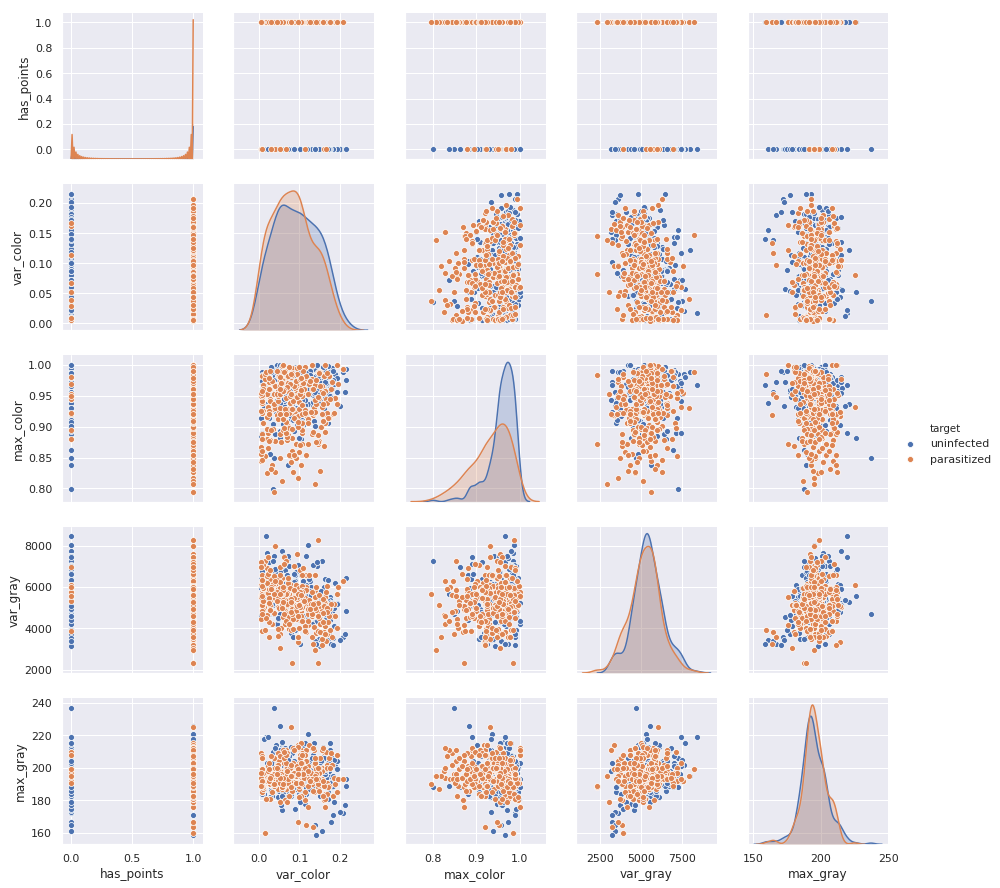

In [38]:
sns.pairplot(data, hue="target")

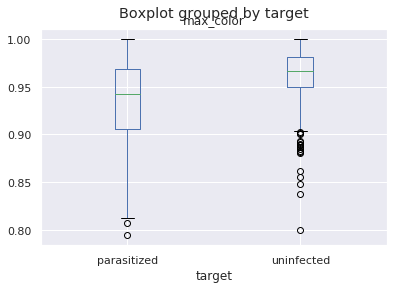

In [140]:
boxplot = data.boxplot(column=['max_color'], by='target')

Let's have a closer look at the points in the cells

In [157]:
nb_par = data.target.value_counts()['parasitized']
data[data['target']=='parasitized'][data['has_points']==1].shape[0]/nb_par * 100

/home/ramine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


96.90721649484536

In [158]:
nb_un = data.target.value_counts()['uninfected']
data[data['target']=='uninfected'][data['has_points']==1].shape[0]/nb_par * 100

/home/ramine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


24.054982817869416

In the 2 previous cells we calculated the percentage of parasitized cells that have points and the percentage of uninfected cells that have points . For parasitized cells it is around 97% whereas for the uninfected cells it is around 24%. Therefore the is a strong correlation between the attribute "has_points" and the target.

There seem to have a pretty strong correlation between the max_color and the target as well.

<div style="background:#FFFFAA">
    <h2>Training a predictive model</h2>
    <p>
We provide an example of predictive model (for classification or regression) in the `sample_code_submission/` directory. It is a quite stupid model: it makes constant predictions. Replace it with your own model.
    </div>

In [93]:
from data_io import write
from model import model
# Uncomment the next line to show the code of the model
#??model 

<div style="background:#FFFFAA">
an instance of the model (run the constructor) and attempt to reload a previously saved version from `sample_code_submission/`:
    
</div>

<div style="background:#FFFFAA">
<h1>Step 2: Building a predictive model</h1>
</div>

<div style="background:#FFFFAA">
    <h2>Loading data with DataManager</h2>
    <p>
We reload the data with the AutoML DataManager class because this is more convenient:
   <br>     <span style="color:red"> Keep this, it illustrates how data in AutoML formal are loaded by the ingestion program </span>
</div>

In [94]:
from data_manager import DataManager
D = DataManager(data_name, data_dir, replace_missing=True)
print(D)

Info file found : /home/ramine/Bureau/AIC/Projet/MediChal-master/starting_kit/sample_data/malaria_public.info
DataManager : malaria
info:
	usage = Malaria cell images dataset
	name = malaria
	task = multiclass.classification
	target_type = Numerical
	feat_type = Numerical
	metric = bac_metric
	time_budget = 1200
	feat_num = 5
	target_num = 2
	label_num = 2
	train_num = 600
	valid_num = 200
	test_num = 200
	has_categorical = 0
	has_missing = 0
	is_sparse = 0
	format = dense
data:
	X_train = array(600, 5)
	Y_train = array(600, 1)
	X_valid = array(200, 5)
	Y_valid = array(200, 1)
	X_test = array(200, 5)
	Y_test = array(200, 1)
feat_type:	array(5,)
feat_idx:	array(0,)



In [95]:
#importation of some classifiers we will test later on 
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm


In [96]:
rand_forest = RandomForestClassifier(random_state=42)
svm = svm.SVC(gamma='scale')
#Trying a random forest model
M = model(rand_forest)
#M = model(svm)
trained_model_name = model_dir + data_name
# Uncomment the next line to re-load an already trained model
#M = M.load(trained_model_name)                  

<div style="background:#FFFFAA">
    Train the model (unless you reloaded a trained model) and make predictions. 
</div>

In [97]:
if not(M.is_trained):
    X_train = D.data['X_train']
    Y_train = D.data['Y_train']
    M.fit(X_train, Y_train)                     

Y_hat_train = M.predict(D.data['X_train']) # Optional, not really needed to test on taining examples
Y_hat_valid = M.predict(D.data['X_valid'])
Y_hat_test = M.predict(D.data['X_test'])

FIT: dim(X)= [600, 5]
FIT: dim(y)= [600, 1]
PREDICT: dim(X)= [600, 5]
PREDICT: dim(y)= [600, 1]
PREDICT: dim(X)= [200, 5]
PREDICT: dim(y)= [200, 1]
PREDICT: dim(X)= [200, 5]
PREDICT: dim(y)= [200, 1]


<div style="background:#FFFFAA">
    <b> Save the trained model </b> (will be ready to reload next time around) and save the prediction results. IMPORTANT: if you save the trained model, it will be bundled with your sample code submission. Therefore your model will NOT be retrained on the challenge platform. Remove the pickle from the submission if you want the model to be retrained on the platform.
</div>

In [98]:
M.save(trained_model_name)                 
result_name = result_dir + data_name
from data_io import write
write(result_name + '_train.predict', Y_hat_train)
write(result_name + '_valid.predict', Y_hat_valid)
write(result_name + '_test.predict', Y_hat_test)
!ls $result_name*

sample_result_submission/malaria_test.predict
sample_result_submission/malaria_train.predict
sample_result_submission/malaria_valid.predict


<div style="background:#FFFFAA">
    <h2>Scoring the results</h2>
    <h3>Load the challenge metric</h3>
    <p>
<b>The metric chosen for your challenge</b> is identified in the "metric.txt" file found in the `scoring_function/` directory. The function "get_metric" searches first for a metric having that name in my_metric.py, then in libscores.py, then in sklearn.metric.
    </div>

In [99]:
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)
# Uncomment the next line to display the code of the scoring metric
#??scoring_function

Using scoring metric: accuracy_score


<div style="background:#FFFFAA">
    <h3> Training performance </h3>
    <p>
The participants normally posess target values (labels) only for training examples (except for the sample data). We compute with the `example` metric the training score, which should be zero for perfect predictions.
        </div>

In [100]:
print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_hat_train))
print('Ideal score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_train))

Training score for the accuracy_score metric = 0.9917
Ideal score for the accuracy_score metric = 1.0000


You can add here other scores and result visualization.

In [101]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_train, Y_hat_train)

array([[307,   2],
       [  3, 288]])

<div style="background:#FFFFAA">
    <h3>Cross-validation performance</h3>
    <p>
The participants do not have access to the labels Y_valid and Y_test to self-assess their validation and test performances. But training performance is not a good prediction of validation or test performance. Using cross-validation, the training data is split into multiple training/test folds, which allows participants to self-assess their model during development. The average CV result and 95% confidence interval is displayed.
   </div>

In [102]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
scores = cross_val_score(M, X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))
print('\nCV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

FIT: dim(X)= [480, 5]
FIT: dim(y)= [480, 1]
PREDICT: dim(X)= [120, 5]
PREDICT: dim(y)= [120, 1]
FIT: dim(X)= [480, 5]
FIT: dim(y)= [480, 1]
PREDICT: dim(X)= [120, 5]
PREDICT: dim(y)= [120, 1]
FIT: dim(X)= [480, 5]
FIT: dim(y)= [480, 1]
PREDICT: dim(X)= [120, 5]
PREDICT: dim(y)= [120, 1]
FIT: dim(X)= [480, 5]
FIT: dim(y)= [480, 1]
PREDICT: dim(X)= [120, 5]
PREDICT: dim(y)= [120, 1]
FIT: dim(X)= [480, 5]
FIT: dim(y)= [480, 1]
PREDICT: dim(X)= [120, 5]
PREDICT: dim(y)= [120, 1]

CV score (95 perc. CI): 0.83 (+/- 0.09)


### The advantage of using a Random forest models is that we can evaluate which feature in taken into account  when predicting the target classes, here you can have an idea of which feature was the most relevant for solving our task

In [130]:
import pandas as pd

feature_importance = pd.DataFrame(M.classifier.feature_importances_,index= list(data)[:5], columns=['feature importance']).sort_values('feature importance', ascending = False)
feature_importance

,feature importance
has_points,0.533263
max_color,0.141417
var_gray,0.117620
var_color,0.112991
max_gray,0.094710




<div style="background:#FFFFAA">
<h1> Step 3: Making a submission </h1> 

<h2> Unit testing </h2> 

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>model.py</code> in the <code>sample_code_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission. 
<br>
Keep the sample code simple.
</div>

In [103]:
!source activate python3; python $problem_dir/ingestion.py $data_dir $result_dir $problem_dir $model_dir

/bin/sh: 1: source: not found
Using input_dir: /home/ramine/Bureau/AIC/Projet/MediChal-master/starting_kit/sample_data
Using output_dir: /home/ramine/Bureau/AIC/Projet/MediChal-master/starting_kit/sample_result_submission
Using program_dir: /home/ramine/Bureau/AIC/Projet/MediChal-master/starting_kit/ingestion_program
Using submission_dir: /home/ramine/Bureau/AIC/Projet/MediChal-master/starting_kit/sample_code_submission

========== Ingestion program version 6 ==========

************************************************
******** Processing dataset Malaria ********
************************************************
========= Reading and converting data ==========
Info file found : /home/ramine/Bureau/AIC/Projet/MediChal-master/starting_kit/sample_data/malaria_public.info
========= Reading /home/ramine/Bureau/AIC/Projet/MediChal-master/starting_kit/sample_data/malaria_feat.type
[+] Success in  0.00 sec
========= Reading /home/ramine/Bureau/AIC/Projet/MediChal-master/starting_kit/sample_data

<div style="background:#FFFFAA">
Also test the scoring program:
    </div>

In [104]:
scoring_output_dir = 'scoring_output'
!source activate python3; python $score_dir/score.py $data_dir $result_dir $scoring_output_dir

/bin/sh: 1: source: not found
======= Set 1 (Malaria_test): accuracy_score(set1_score)=0.840000000000 =======
======= Set 2 (Malaria_train): accuracy_score(set2_score)=0.991666666667 =======
======= Set 3 (Malaria_valid): accuracy_score(set3_score)=0.810000000000 =======


<div style="background:#FFFFAA">
    <h1> Preparing the submission </h1>

Zip the contents of `sample_code_submission/` (without the directory), or download the challenge public_data and run the command in the previous cell, after replacing sample_data by public_data.
Then zip the contents of `sample_result_submission/` (without the directory).
<b><span style="color:red">Do NOT zip the data with your submissions</span></b>.

In [105]:
import datetime 
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = '../sample_code_submission_' + the_date + '.zip'
sample_result_submission = '../sample_result_submission_' + the_date + '.zip'
zipdir(sample_code_submission, model_dir)
zipdir(sample_result_submission, result_dir)
print("Submit one of these files:\n" + sample_code_submission + "\n" + sample_result_submission)

Submit one of these files:
../sample_code_submission_19-09-28-13-27.zip
../sample_result_submission_19-09-28-13-27.zip
